# Welcome to the Study Notebook where measures are pre-processed, cleaned, plotted and transformed
## Here, will be covered the measurements done using powerstat and the energy service 
### Most of these final results are saved in summary/

In [17]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import csv



## Please modify csv_dir_idle / csv_dir_img in order to switch experiments (idle or imaging)
### Here, energy_logs csv files are converted to dfs

## Convert to dataframe

In [ ]:
import glob

csv_dir_idle = 'data/baseline_on_track/energy_logs' 
csv_dir_img = 'data/final_intervention_on_track/energy_logs'  

# Pattern to match energy_logs files
pattern_idle = os.path.join(csv_dir_idle, 'energy_logs_*.csv')
pattern_img = os.path.join(csv_dir_img, 'energy_logs_*.csv')

dataframes_idle = {}
dataframes_img = {}


# IDLE
for file_path in sorted(glob.glob(pattern_idle)):
    df_name = os.path.splitext(os.path.basename(file_path))[0]
    dataframes_idle[df_name] = pd.read_csv(file_path)

# for name, df in dataframes_idle.items():
    # print(f"DF IDLE: {name}: {len(df)} rows")

# IMG
for file_path in sorted(glob.glob(pattern_img)):
    df_name = os.path.splitext(os.path.basename(file_path))[0]
    dataframes_img[df_name] = pd.read_csv(file_path)

# for name, df in dataframes_img.items():
    # print(f"DF IMG: {name}: {len(df)} rows")


# Violin Plots for imaging and idle 

/var/folders/87/xbc8k_k17_n921xhcp1k1hnc0000gn/T/ipykernel_72758/2189129970.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


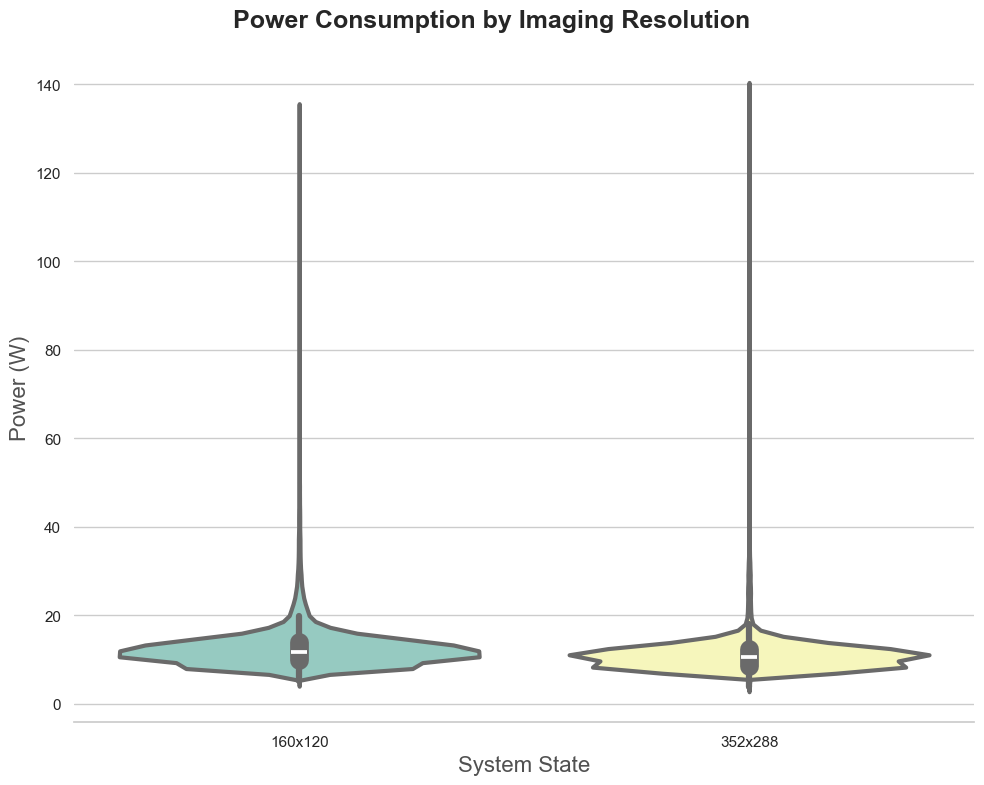

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Extract power values into a single DataFrame
def extract_power_from_dict(df_dict, label):
    power_values = []
    for df in df_dict.values():
        if 'power_watts' not in df.columns:
            raise KeyError("'power_watts' column not found.")
        power_values.extend(df['power_watts'].values)
    return pd.DataFrame({'Power (W)': power_values, 'State': label})

# Create the combined DataFrame
idle_df = extract_power_from_dict(dataframes_idle, '160x120')
img_df = extract_power_from_dict(dataframes_img, '352x288')
combined_df = pd.concat([idle_df, img_df], ignore_index=True)

f, ax = plt.subplots(figsize=(10, 8))  

sns.violinplot(
    x="State",
    y="Power (W)",
    data=combined_df,
    inner="box",
    palette="Set3",
    cut=2,
    linewidth=3
)

sns.despine(left=True)

f.suptitle('Power Consumption by Imaging Resolution', fontsize=18, fontweight='bold')
ax.set_xlabel("System State", size=16, alpha=0.8)
ax.set_ylabel("Power (W)", size=16, alpha=0.8)

plt.tight_layout()
plt.show()


In [20]:
print(len(set(combined_df['Power (W)'])))
print(combined_df['Power (W)'].nunique())

2286
2286


## Check Total Average Power for imaging and idle

In [7]:
# IMAGING
total_power_img = 0

for name, df in dataframes_img.items():
    power = df['power_watts']
    average_power = power.mean()
    # print(f"Average Power for IMG {name}: {average_power:.2f} W")
    total_power_img += average_power

overall_average = total_power_img / len(dataframes_img)
print(f"\nOverall average power across all runs IMAGING: {overall_average:.2f} W")

# IDLE
total_power_idle = 0

for name, df in dataframes_idle.items():
    power = df['power_watts']
    average_power = power.mean()
    # print(f"Average Power for IDLE {name}: {average_power:.2f} W")
    total_power_idle += average_power

overall_average = total_power_idle / len(dataframes_idle)
print(f"\nOverall average power across all runs IDLE: {overall_average:.2f} W")




Overall average power across all runs IMAGING: 11.13 W

Overall average power across all runs IDLE: 12.73 W


# Delta for battery consumption for img and idle
## This is computed by taking the average supply data of the last experiment - the average supply data of the first experiment

In [8]:
def compute_voltage_drop(df_dict):
    # Get first and last DataFrames
    first_df = df_dict['energy_logs_00']
    last_df = df_dict['energy_logs_29']

    # Compute average voltage
    avg_v_first = first_df['supply_voltage'].mean()
    avg_v_last = last_df['supply_voltage'].mean()

    delta_v = avg_v_first - avg_v_last

    return avg_v_first, avg_v_last, delta_v

v_first_idle, v_last_idle, delta_v_idle = compute_voltage_drop(dataframes_idle)
v_first_img, v_last_img, delta_v_img = compute_voltage_drop(dataframes_img)

# Print nicely
print(f"[IDLE]   V_start: {v_first_idle:.3f} V   V_end: {v_last_idle:.3f} V   Drop: {delta_v_idle:.3f} V")
print(f"[IMG]    V_start: {v_first_img:.3f} V   V_end: {v_last_img:.3f} V   Drop: {delta_v_img:.3f} V")


[IDLE]   V_start: 16.490 V   V_end: 15.912 V   Drop: 0.578 V
[IMG]    V_start: 16.447 V   V_end: 15.930 V   Drop: 0.517 V


# Powerstat 


## Convert to df for data and for summary of powerstat

In [9]:
import pandas as pd

def load_powerstat_csv(path):
    """
    Load and split a powerstat CSV file into:
    - data_df: detailed time-series measurements
    - summary_df: summary stats like average, stddev, etc.
    """
    with open(path, 'r') as f:
        lines = f.readlines()

    data_rows = []
    summary_rows = []
    capture_data = True

    for line in lines:
        line = line.strip()
        
        # Skip footer
        if line.startswith("Summary:") or line.startswith("System:"):
            continue
        
        # Detect table dividers (e.g., '--------')
        if re.match(r"^-{3,}", line):
            capture_data = False
            continue
        
        # Capture lines
        if capture_data and re.match(r"^\d{2}:\d{2}:\d{2}", line):
            data_rows.append(re.split(r"\s+", line))
        elif not capture_data and re.match(r"^(Average|GeoMean|StdDev|Minimum|Maximum)", line):
            summary_rows.append(re.split(r"\s+", line))

    # Define shared column headers
    columns = ["Time", "User", "Nice", "Sys", "Idle", "IO", "Run", "Ctxt/s", "IRQ/s", "Watts", "soc-th", "cpu-th"]

    # Create data DataFrame
    data_df = pd.DataFrame(data_rows, columns=columns)
    for col in data_df.columns[1:]:  # Skip 'Time'
        data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_rows, columns=columns)
    for col in summary_df.columns[1:]:
        summary_df[col] = pd.to_numeric(summary_df[col], errors='coerce')

    return data_df, summary_df


### Define paths for powerstat, depending on the scenario

In [10]:
state = 'img'  # or 'idle'

# Define your paths, plots with all three variables
before_path = f"data/before_intervention/battery_1min_600Hz({state})/powerstat.csv"
powersave_path = f"data/powersave_intervention/battery_1min_600Hz({state})/powerstat.csv"
conservative_path = f"data/conservative_intervention/battery_1min_600Hz({state})/powerstat.csv"

# Load each file
before_data, before_summary = load_powerstat_csv(before_path)
powersave_data, powersave_summary = load_powerstat_csv(powersave_path)
conservative_data, conservative_summary = load_powerstat_csv(conservative_path)

# Define your paths, plots with two variables
three_cpu = 'data/baseline_on_track/powerstat.csv' # # 352x288 , powersave, baseline on track
one_cpu = 'data/final_intervention_on_track/powerstat.csv' # 160x80, conservative, final on track

# Load each file
three_data, three_summary = load_powerstat_csv(three_cpu)
one_data, one_summary = load_powerstat_csv(one_cpu)
# six_data, six_summary = load_powerstat_csv(six_cpu)    

three_data['cpu-th']

0       45.0
1       46.0
2       46.0
3       46.0
4       46.0
        ... 
4563    46.0
4564    46.0
4565    46.0
4566    46.0
4567    46.0
Name: cpu-th, Length: 4568, dtype: float64

## Plot Temperatures against Time: CPU-th, SOC-th

## Plot temp for the 2 different resolutions

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_relative_cpu_temp(df, label):
    # Convert Time to datetime
    df = df.copy()
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Calculate relative time in minutes
    t0 = df['Time'].iloc[0]
    df['ElapsedMin'] = (df['Time'] - t0).dt.total_seconds() // 60  # integer minutes

    # Group by elapsed minute and compute mean CPU temperature
    temp_df = df.groupby('ElapsedMin')['cpu-th'].mean().reset_index()
    temp_df['Governor'] = label
    return temp_df

# Preprocess two datasets
# Change params depending on the experiment needed to be plotted
three_cpu = preprocess_relative_cpu_temp(three_data, 'Baseline')
one_cpu = preprocess_relative_cpu_temp(one_data, 'Final')

# Combine into one dataframe
cpu_df_all = pd.concat([three_cpu, one_cpu])


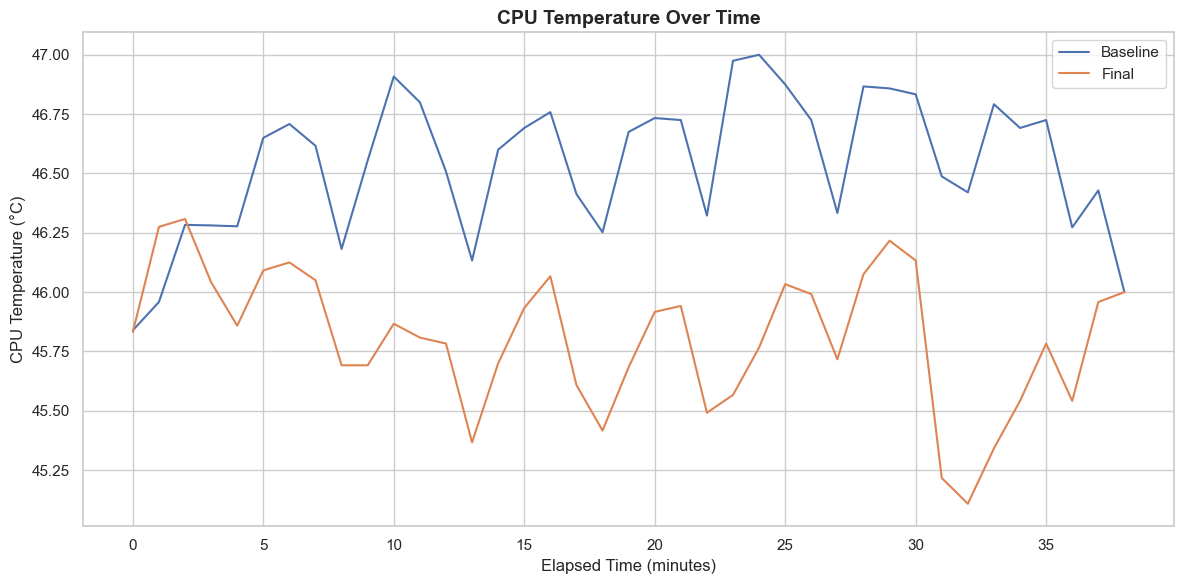

In [12]:
plt.figure(figsize=(12, 6))
for gov in cpu_df_all['Governor'].unique():
    gov_data = cpu_df_all[cpu_df_all['Governor'] == gov]
    plt.plot(gov_data['ElapsedMin'], gov_data['cpu-th'], label=gov)

plt.title("CPU Temperature Over Time", fontsize=14, weight='bold')
plt.xlabel("Elapsed Time (minutes)")
plt.ylabel("CPU Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot CPU temperature for all three governors / resolutions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_relative_cpu_temp(df, label):
    # Convert Time to datetime
    df = df.copy()
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Calculate relative time in seconds
    t0 = df['Time'].iloc[0]
    df['ElapsedMin'] = (df['Time'] - t0).dt.total_seconds() // 60  # integer minutes

    # Group by elapsed minute and compute mean CPU temperature
    temp_df = df.groupby('ElapsedMin')['cpu-th'].mean().reset_index()
    temp_df['Governor'] = label
    return temp_df

before = preprocess_relative_cpu_temp(before_data, 'Ondemand')
powersave = preprocess_relative_cpu_temp(powersave_data, 'Powersave')
conservative = preprocess_relative_cpu_temp(conservative_data, 'Conservative')

# Combine into one dataframe
cpu_df_all = pd.concat([before, powersave, conservative])


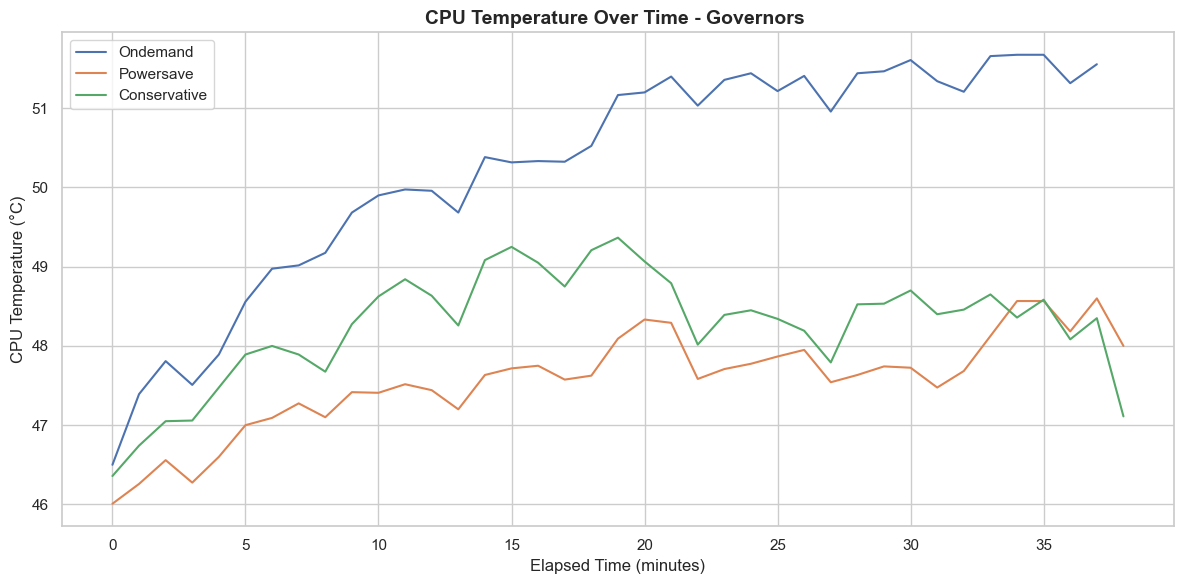

In [14]:
# Plot
plt.figure(figsize=(12, 6))
for gov in cpu_df_all['Governor'].unique():
    gov_data = cpu_df_all[cpu_df_all['Governor'] == gov]
    plt.plot(gov_data['ElapsedMin'], gov_data['cpu-th'], label=gov)

plt.title("CPU Temperature Over Time - Governors ", fontsize=14, weight='bold')
plt.xlabel("Elapsed Time (minutes)")
plt.ylabel("CPU Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Average Power per Resolutions / per Governors
Change paths to switch for governors

In [ ]:
import glob

csv_dir_small = 'data/imaging_intervention/imaging_160/energy_logs' 
csv_dir_inter = 'data/imaging_intervention/imaging_352/energy_logs'  
csv_dir_default = 'data/before_intervention/battery_1min_600Hz(img)/energy_logs' 

# Pattern to match energy_logs files
pattern_small = os.path.join(csv_dir_small, 'energy_logs_*.csv')
pattern_inter = os.path.join(csv_dir_inter, 'energy_logs_*.csv')
pattern_default = os.path.join(csv_dir_default, 'energy_logs_*.csv')

dataframes_small = {}
dataframes_inter = {}
dataframes_default = {}

# small
for file_path in sorted(glob.glob(pattern_small)):
    df_name = os.path.splitext(os.path.basename(file_path))[0]
    dataframes_small[df_name] = pd.read_csv(file_path)

# intermediate
for file_path in sorted(glob.glob(pattern_inter)):
    df_name = os.path.splitext(os.path.basename(file_path))[0]
    dataframes_inter[df_name] = pd.read_csv(file_path)

# default
for file_path in sorted(glob.glob(pattern_default)):
    df_name = os.path.splitext(os.path.basename(file_path))[0]
    dataframes_default[df_name] = pd.read_csv(file_path)




In [16]:
# average power over all runs of each experiment for the resolutions / governors
def compute_average_power(pattern):
    csv_files = glob.glob(pattern)
    total_power = 0
    total_rows = 0
    for file in csv_files:
        df = pd.read_csv(file)
        total_power += df['power_watts'].sum()
        total_rows += df.shape[0]
        avg_power = total_power / total_rows 
    return round(avg_power ,2)

# Compute average power per path
avg_power_small = compute_average_power(pattern_small)
avg_power_inter = compute_average_power(pattern_inter)
avg_power_default = compute_average_power(pattern_default)

# Collect results
average_powers = {
    'small': avg_power_small,
    'inter': avg_power_inter,
    'default': avg_power_default
}

average_powers

{'small': np.float64(7.24),
 'inter': np.float64(7.37),
 'default': np.float64(7.51)}